In [2]:
# Khai báo thư viện cần thiết 
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import shutil
from pathlib import Path
import albumentations as A
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [12]:
# Khai báo các tham số cần thiết
# ==================== CẤU HÌNH ====================
IMAGE_DIR = r"D:\archive\images"
XML_DIR = r"D:\archive\xmls" 
OUTPUT_DIR = "archive"  # Thư mục chứa kết quả cuối cùng

TARGET_SIZE = (640, 640) # (height, width)
RARE_THRESHOLD = 300 
VERY_COMMON_THRESHOLD = 1000 
AUGMENTATION_FACTOR_RARE = 2
AUGMENTATION_FACTOR_COMMON = 0

# --- CẤU HÌNH TÍNH NĂNG MỚI ---
SHOW_SAMPLE_ON_RUN = True  # Đặt là True để xem ảnh mẫu, False để bỏ qua
# =================================================



=== BƯỚC 1: LỌC DỮ LIỆU ĐẦU VÀO ===
Tổng số file ảnh tìm thấy: 20087
Tổng số file XML tìm thấy: 19346
Số cặp file ảnh-XML hợp lệ sẽ được xử lý: 19346


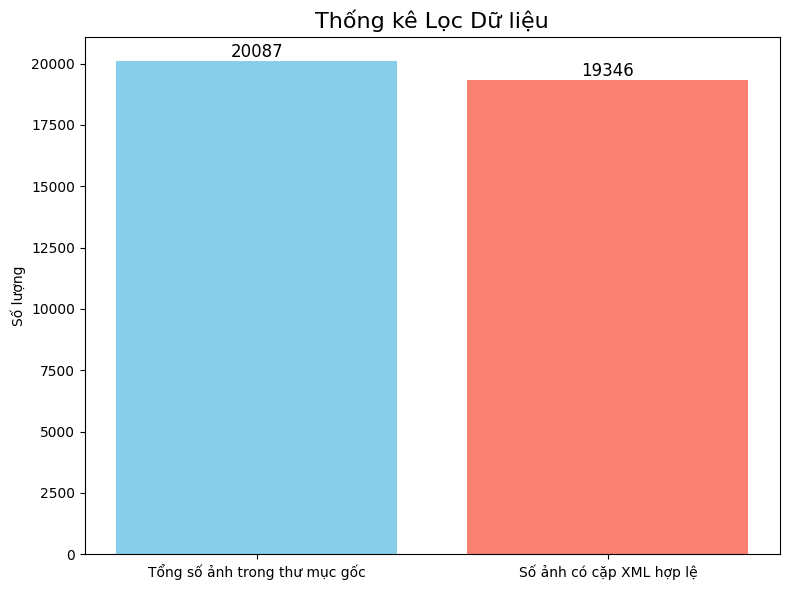


=== BƯỚC 2: PHÂN TÍCH LỚP BAN ĐẦU ===

Đang quét thư mục 'D:\archive\xmls' để đếm các lớp...


Đếm lớp: 100%|██████████| 19346/19346 [01:37<00:00, 198.82it/s] 



Thống kê số lượng các lớp GỐC:
- regulatory--pass-on-either-side: 137
- information--tram-bus-stop: 156
- information--hospital: 197
- warning--delineator--right: 199
- regulatory--turn-left-or-right: 201
- warning--traffic-merges-left: 204
- warning--delineator: 206
- warning--road-slope-right: 206
- warning--road-slope-left: 207
- warning--road-dip: 207
- regulatory--no-goods-vehicles-exceeding-limit: 209
- warning--falling-rocks-or-debris-left: 210
- warning--delineator--left: 212
- regulatory--axel-mass-limit: 214
- regulatory--no-goods-vehicles: 221
- information--gas-station: 231
- warning--domestic-animals: 232
- regulatory--no-buses: 232
- warning--falling-rocks-or-debris-right: 235
- warning--bicycles-crossing: 235
- warning--wild-animals: 236
- regulatory--pedestrians-only: 239
- regulatory--no-motor-vehicles: 240
- regulatory--yield-to-oncoming-traffic: 242
- regulatory--no-parking: 242
- warning--road-narrows-right: 242
- regulatory--no-bicycles: 244
- warning--road-narrow

Đang xử lý ảnh:   0%|          | 0/19346 [00:00<?, ?it/s]


Đang hiển thị ảnh mẫu... (Hãy đóng cửa sổ ảnh để tiếp tục quá trình)


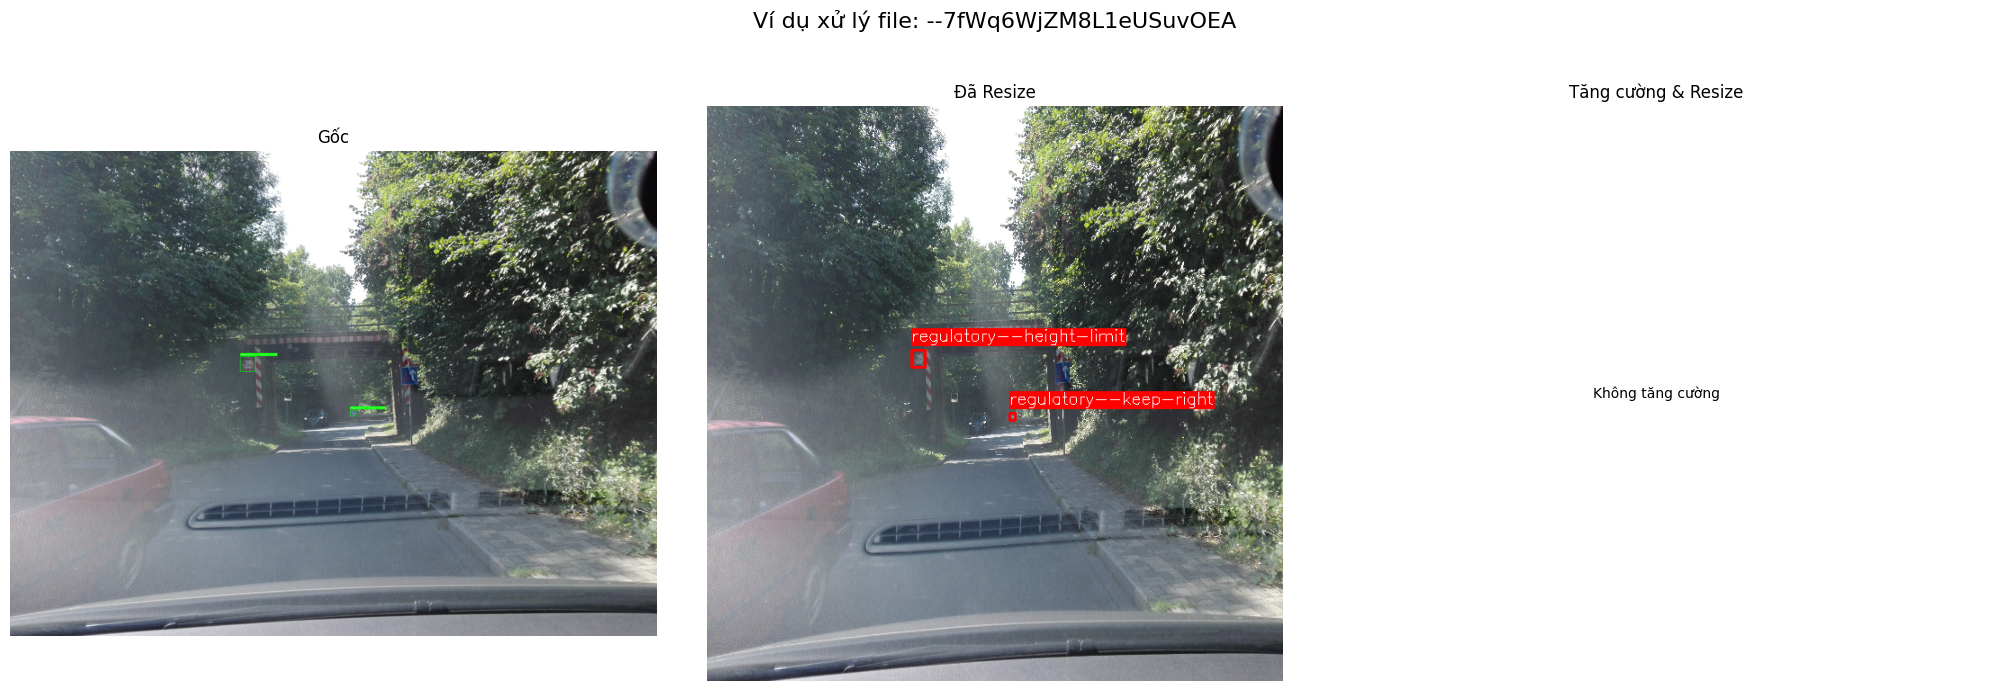

Đang xử lý ảnh:  17%|█▋        | 3325/19346 [01:51<09:12, 28.99it/s]


Lỗi khi xử lý 0005646: Expected x_max for bbox [ 0.9270833   0.34166667  1.0067708   0.4611111  29.        ] to be in the range [0.0, 1.0], got 1.0067708492279053.


Đang xử lý ảnh: 100%|██████████| 19346/19346 [20:38<00:00, 15.62it/s]



=== HOÀN THÀNH ===
Toàn bộ ảnh trong thư mục đầu ra đã được resize về (640, 640).
Tổng số ảnh trong thư mục 'archive': 31913

=== BƯỚC 4: THỐNG KÊ KẾT QUẢ ===

Đang quét thư mục 'archive\annotations' để đếm các lớp...


Đếm lớp: 100%|██████████| 31913/31913 [05:33<00:00, 95.81it/s] 



Thống kê số lượng các lớp SAU KHI XỬ LÝ:
- regulatory--pass-on-either-side: 285
- information--tram-bus-stop: 402
- warning--crossroads: 439
- warning--traffic-signals: 446
- complementary--chevron-right: 454
- warning--curve-left: 464
- warning--curve-right: 476
- information--motorway: 481
- regulatory--no-pedestrians: 485
- regulatory--bicycles-only: 487
- warning--junction-with-a-side-road-perpendicular-right: 489
- regulatory--roundabout: 492
- regulatory--turn-left: 493
- regulatory--weight-limit: 498
- warning--railroad-crossing-without-barriers: 503
- warning--children: 504
- warning--slippery-road-surface: 506
- regulatory--no-heavy-goods-vehicles: 512
- regulatory--go-straight: 525
- warning--delineator--right: 540
- information--hospital: 540
- warning--road-bump: 543
- complementary--distance: 550
- regulatory--turn-left-or-right: 564
- warning--road-slope-left: 566
- warning--delineator: 567
- warning--road-dip: 567
- regulatory--turn-right: 568
- regulatory--axel-mass-li

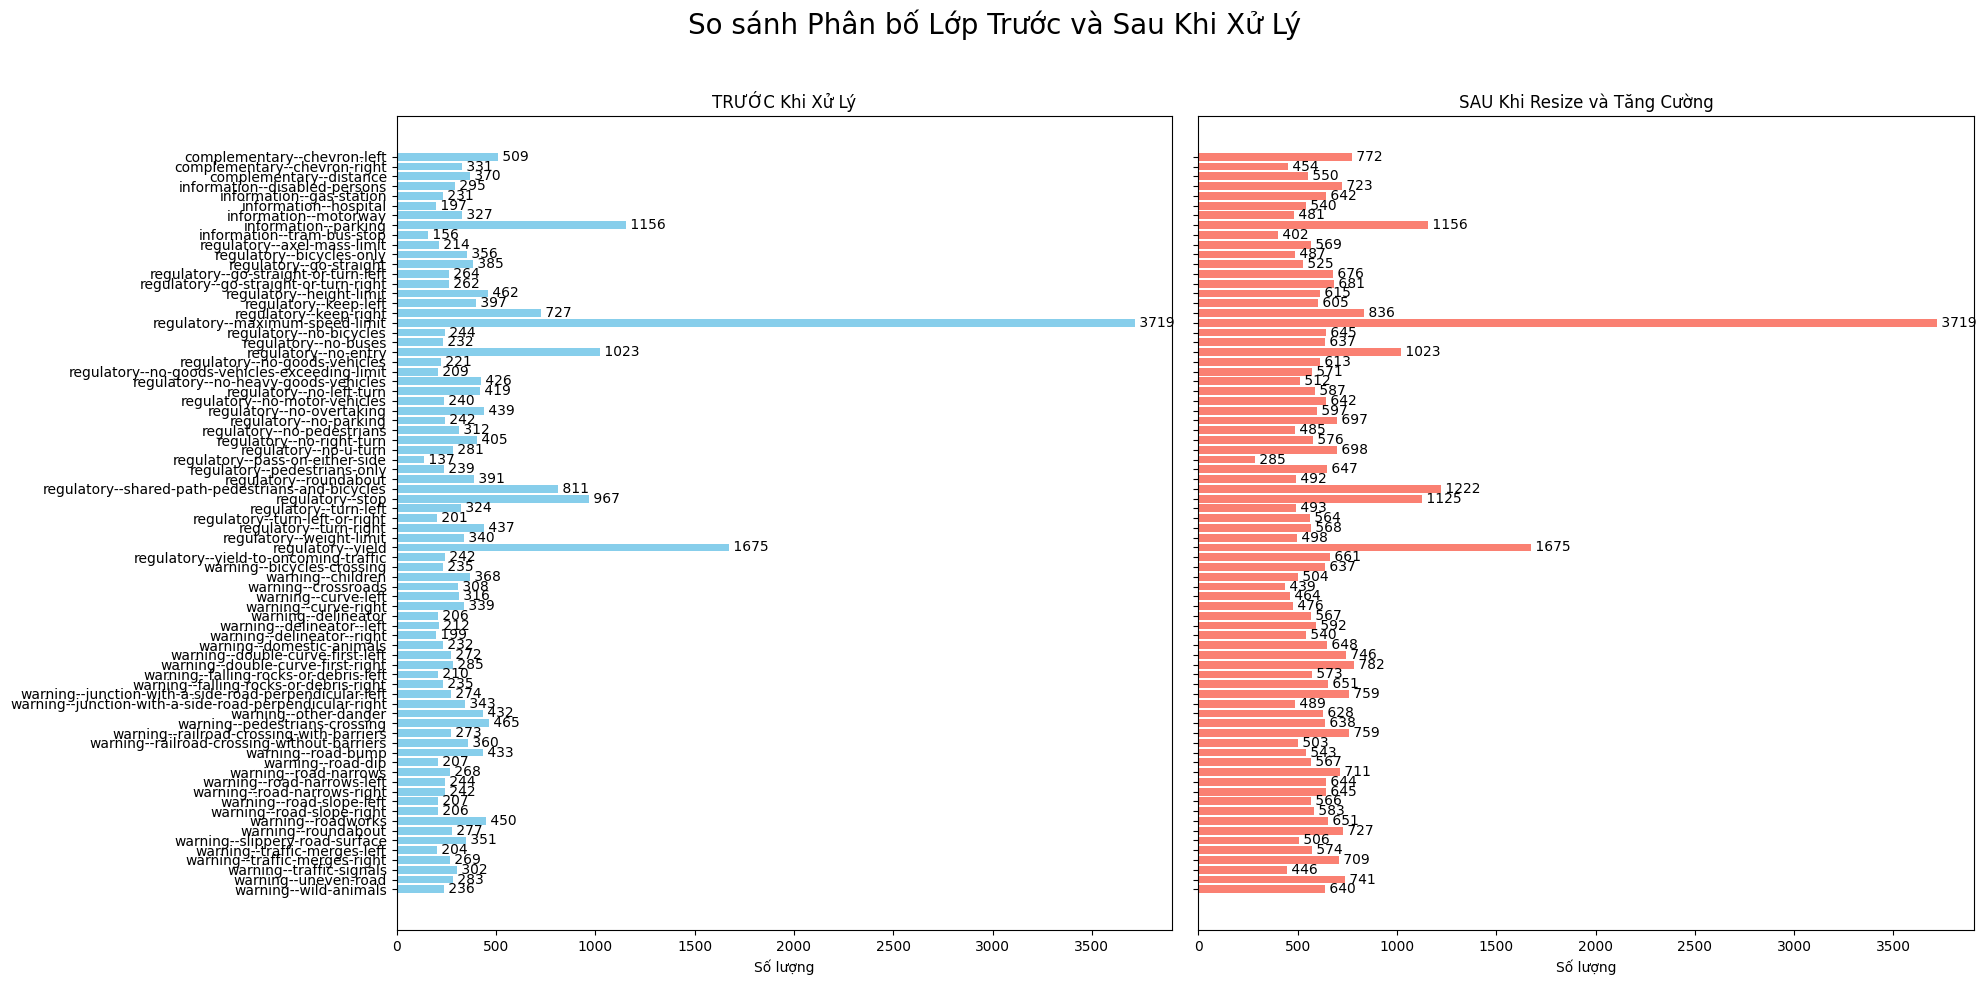

In [ ]:
# ==================== CÁC HÀM PHỤ TRỢ ====================

def create_directory_if_not_exists(path):
    Path(path).mkdir(parents=True, exist_ok=True)

def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    objects = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(float(bndbox.find('xmin').text))
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))
        objects.append({'name': name, 'bbox': [xmin, ymin, xmax, ymax]})
    return objects

def create_xml(filename, width, height, objects, output_path):
    root = ET.Element("annotation")
    ET.SubElement(root, "folder").text = "images"
    ET.SubElement(root, "filename").text = filename
    source = ET.SubElement(root, "source")
    ET.SubElement(source, "database").text = "Unknown"
    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text = str(width)
    ET.SubElement(size, "height").text = str(height)
    ET.SubElement(size, "depth").text = "3"
    ET.SubElement(root, "segmented").text = "0"
    for obj in objects:
        object_elem = ET.SubElement(root, "object")
        ET.SubElement(object_elem, "name").text = obj['name']
        ET.SubElement(object_elem, "pose").text = "Unspecified"
        ET.SubElement(object_elem, "truncated").text = "0"
        ET.SubElement(object_elem, "difficult").text = "0"
        bndbox = ET.SubElement(object_elem, "bndbox")
        ET.SubElement(bndbox, "xmin").text = str(int(obj['bbox'][0]))
        ET.SubElement(bndbox, "ymin").text = str(int(obj['bbox'][1]))
        ET.SubElement(bndbox, "xmax").text = str(int(obj['bbox'][2]))
        ET.SubElement(bndbox, "ymax").text = str(int(obj['bbox'][3]))
    tree = ET.ElementTree(root)
    ET.indent(tree, space="\t", level=0)
    tree.write(output_path, encoding='utf-8')

def plot_filtering_stats(total_before_filter, total_after_filter):
    """(CẬP NHẬT) Vẽ biểu đồ 2 cột: Trước và Sau khi lọc."""
    if plt is None: return
    
    labels = ['Tổng số ảnh trong thư mục gốc', 'Số ảnh có cặp XML hợp lệ']
    counts = [total_before_filter, total_after_filter]
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, counts, color=['skyblue', 'salmon'])
    plt.ylabel('Số lượng')
    plt.title('Thống kê Lọc Dữ liệu', fontsize=16)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=12)
        
    plt.tight_layout()
    plt.show()

def filter_matched_files():
    """(CẬP NHẬT) Lọc file và gọi hàm vẽ biểu đồ mới."""
    image_files = {f.stem for f in Path(IMAGE_DIR).glob("*.*") if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']}
    xml_files = {f.stem for f in Path(XML_DIR).glob("*.xml")}
    
    image_count = len(image_files)
    xml_count = len(xml_files)
    
    matched_stems = sorted(list(image_files.intersection(xml_files)))
    matched_count = len(matched_stems)

    print(f"Tổng số file ảnh tìm thấy: {image_count}")
    print(f"Tổng số file XML tìm thấy: {xml_count}")
    print(f"Số cặp file ảnh-XML hợp lệ sẽ được xử lý: {matched_count}")
    
    # Gọi hàm vẽ biểu đồ với 2 giá trị
    plot_filtering_stats(image_count, matched_count)
    
    return matched_stems

def get_class_counts(xml_directory):
    class_counter = Counter()
    print(f"\nĐang quét thư mục '{xml_directory}' để đếm các lớp...")
    xml_paths = list(Path(xml_directory).glob("*.xml"))
    for xml_path in tqdm(xml_paths, desc="Đếm lớp"):
        try:
            objects = parse_xml(xml_path)
            for obj in objects: class_counter[obj['name']] += 1
        except Exception as e: print(f"Lỗi khi đọc file {xml_path}: {e}")
    return class_counter

def augment_image(image, objects, transform):
    bboxes = [obj['bbox'] for obj in objects]
    class_labels = [obj['name'] for obj in objects]
    transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    aug_image = transformed['image']
    aug_bboxes = transformed['bboxes']
    aug_objects = []
    for i, bbox in enumerate(aug_bboxes):
        if bbox[2] > bbox[0] and bbox[3] > bbox[1]:
            aug_objects.append({'name': transformed['class_labels'][i], 'bbox': list(bbox)})
    return aug_image, aug_objects

def draw_bboxes_on_image(image, objects, color=(255, 0, 0), thickness=2):
    img_copy = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2BGR)
    for obj in objects:
        name, (xmin, ymin, xmax, ymax) = obj['name'], [int(c) for c in obj['bbox']]
        cv2.rectangle(img_copy, (xmin, ymin), (xmax, ymax), color, thickness)
        label = f"{name}"
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        cv2.rectangle(img_copy, (xmin, ymin - h - 10), (xmin + w, ymin - 5), color, -1)
        cv2.putText(img_copy, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
    return cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB)

def plot_class_distribution_charts(original_counts, augmented_counts, output_dir):
    if plt is None: return
    all_labels = sorted(list(set(original_counts.keys()) | set(augmented_counts.keys())))
    original_values = [original_counts.get(label, 0) for label in all_labels]
    augmented_values = [augmented_counts.get(label, 0) for label in all_labels]
    y_pos = np.arange(len(all_labels))
    fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
    fig.suptitle('So sánh Phân bố Lớp Trước và Sau Khi Xử Lý', fontsize=20)
    axes[0].barh(y_pos, original_values, align='center', color='skyblue')
    axes[0].set_yticks(y_pos); axes[0].set_yticklabels(all_labels); axes[0].invert_yaxis()
    axes[0].set_xlabel('Số lượng'); axes[0].set_title('TRƯỚC Khi Xử Lý')
    for i, v in enumerate(original_values): axes[0].text(v, i, f' {v}', va='center')
    axes[1].barh(y_pos, augmented_values, align='center', color='salmon')
    axes[1].set_xlabel('Số lượng'); axes[1].set_title('SAU Khi Resize và Tăng Cường')
    for i, v in enumerate(augmented_values): axes[1].text(v, i, f' {v}', va='center')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    chart_path = os.path.join(output_dir, "class_distribution_comparison.png")
    plt.savefig(chart_path)
    print(f"\nĐã lưu biểu đồ phân bố lớp tại: {chart_path}")
    plt.show()

# ==================== HÀM CHÍNH ====================
def main():
    create_directory_if_not_exists(os.path.join(OUTPUT_DIR, "images"))
    create_directory_if_not_exists(os.path.join(OUTPUT_DIR, "annotations"))

    print("\n=== BƯỚC 1: LỌC DỮ LIỆU ĐẦU VÀO ===")
    matched_files = filter_matched_files()

    print("\n=== BƯỚC 2: PHÂN TÍCH LỚP BAN ĐẦU ===")
    original_class_counts = get_class_counts(XML_DIR)
    print("\nThống kê số lượng các lớp GỐC:")
    for name, count in sorted(original_class_counts.items(), key=lambda item: item[1]): print(f"- {name}: {count}")
    rare_classes = {n for n, c in original_class_counts.items() if c < RARE_THRESHOLD}
    very_common_classes = {n for n, c in original_class_counts.items() if c > VERY_COMMON_THRESHOLD}
    print(f"\nCác lớp HIẾM (dưới {RARE_THRESHOLD}): {sorted(list(rare_classes)) if rare_classes else 'Không có'}")
    print(f"Các lớp RẤT PHỔ BIẾN (trên {VERY_COMMON_THRESHOLD}): {sorted(list(very_common_classes)) if very_common_classes else 'Không có'}")
    
    transform_resize_only = A.Compose([A.Resize(height=TARGET_SIZE[0], width=TARGET_SIZE[1], p=1.0)], 
                                      bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
    transform_augment = A.Compose([A.Resize(height=TARGET_SIZE[0], width=TARGET_SIZE[1], p=1.0),
        A.HorizontalFlip(p=0.5), A.ShiftScaleRotate(p=0.6), A.RandomBrightnessContrast(p=0.5)],
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_visibility=0.2))

    print("\n=== BƯỚC 3: RESIZE VÀ TĂNG CƯỜNG DỮ LIỆU ===")
    total_output_images, sample_shown = 0, False

    for file_stem in tqdm(matched_files, desc="Đang xử lý ảnh"):
        try:
            image_path_obj = next(Path(IMAGE_DIR).glob(f"{file_stem}.*"), None)
            if not image_path_obj: continue
            objects = parse_xml(Path(XML_DIR) / f"{file_stem}.xml")
            if not objects: continue

            image_rgb = cv2.cvtColor(cv2.imread(str(image_path_obj)), cv2.COLOR_BGR2RGB)
            resized_image, resized_objects = augment_image(image_rgb, objects, transform_resize_only)
            cv2.imwrite(str(Path(OUTPUT_DIR)/'images'/image_path_obj.name), cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))
            create_xml(image_path_obj.name, TARGET_SIZE[1], TARGET_SIZE[0], resized_objects, str(Path(OUTPUT_DIR)/'annotations'/f"{file_stem}.xml"))
            total_output_images += 1
            
            image_classes = {obj['name'] for obj in objects}
            num_augmentations = 0
            if not any(c in very_common_classes for c in image_classes):
                num_augmentations = AUGMENTATION_FACTOR_RARE if any(c in rare_classes for c in image_classes) else AUGMENTATION_FACTOR_COMMON

            first_aug_image, first_aug_objects = None, None
            for j in range(num_augmentations):
                aug_image, aug_objects = augment_image(image_rgb, objects, transform_augment)
                if aug_objects:
                    if j == 0: first_aug_image, first_aug_objects = aug_image, aug_objects
                    aug_filename = f"{file_stem}_aug_{j+1}.jpg"
                    cv2.imwrite(str(Path(OUTPUT_DIR)/'images'/aug_filename), cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
                    create_xml(aug_filename, TARGET_SIZE[1], TARGET_SIZE[0], aug_objects, str(Path(OUTPUT_DIR)/'annotations'/f"{file_stem}_aug_{j+1}.xml"))
                    total_output_images += 1

            if SHOW_SAMPLE_ON_RUN and not sample_shown and plt:
                print("\nĐang hiển thị ảnh mẫu... (Hãy đóng cửa sổ ảnh để tiếp tục quá trình)")
                fig, axes = plt.subplots(1, 3, figsize=(20, 7)); fig.suptitle(f"Ví dụ xử lý file: {file_stem}", fontsize=16)
                axes[0].imshow(draw_bboxes_on_image(image_rgb, objects, color=(0, 255, 0))); axes[0].set_title(f"Gốc"); axes[0].axis('off')
                axes[1].imshow(draw_bboxes_on_image(resized_image, resized_objects, color=(0, 0, 255))); axes[1].set_title(f"Đã Resize"); axes[1].axis('off')
                if first_aug_image:
                    axes[2].imshow(draw_bboxes_on_image(first_aug_image, first_aug_objects, color=(255, 0, 0))); axes[2].set_title("Tăng cường & Resize")
                else:
                    axes[2].text(0.5, 0.5, "Không tăng cường", ha='center', va='center'); axes[2].set_title("Tăng cường & Resize")
                axes[2].axis('off'); plt.tight_layout(rect=[0,0,1,0.95]); plt.show()
                sample_shown = True

        except Exception as e: print(f"\nLỗi khi xử lý {file_stem}: {e}")
    
    print(f"\n=== HOÀN THÀNH ===")
    print(f"Toàn bộ ảnh trong thư mục đầu ra đã được resize về {TARGET_SIZE}.")
    print(f"Tổng số ảnh trong thư mục '{OUTPUT_DIR}': {total_output_images}")

    print("\n=== BƯỚC 4: THỐNG KÊ KẾT QUẢ ===")
    processed_xml_dir = os.path.join(OUTPUT_DIR, "annotations")
    augmented_class_counts = get_class_counts(processed_xml_dir)
    print("\nThống kê số lượng các lớp SAU KHI XỬ LÝ:")
    for name, count in sorted(augmented_class_counts.items(), key=lambda item: item[1]): print(f"- {name}: {count}")
    plot_class_distribution_charts(original_class_counts, augmented_class_counts, OUTPUT_DIR)

if __name__ == "__main__":
    main()